# Introduction 

This notebook is a quick workflow to use with ELK and browse threat indexed. The goal is to provide a ready to use workflow to identify particular threat, statistics and do an initial threat analysis.  

# Library Import

The list of the below library are required to run this notebook. You may need to install them with pip.

In [11]:
import requests
import magic
import json
import matplotlib
import pandas as pd
import datetime
import requests
import pefile
import peutils
import matplotlib.pyplot as plt
import os
from elasticsearch import Elasticsearch
from ssl import create_default_context

# Elastic Connection

The first thing to do is to check if the connection to your Elastic instance is working.

In [12]:
# Test Connection
#res = requests.get('')
#json_res = json.loads(res.content)
#print(json.dumps(json_res, sort_keys=True, indent=4))

#context = create_default_context(cafile='/Users/fr0gger/Documents/malware_notebook/elasticsearch-ca.pem')

# ES Variable
#es = Elasticsearch([{'host': '192.168.1.10', 'port': 9200}], scheme="http", port=9200)

es = Elasticsearch("http://192.168.1.x:9200")

#Elasticsearch
es.indices.get_alias()

C:\Users\THOMAS~1\AppData\Local\Temp/ipykernel_16824/2159707398.py:14: ElasticsearchWarning: this request accesses system indices: [.security-7, .apm-custom-link, .kibana_8.4.2_001, .apm-agent-configuration, .kibana_task_manager_8.4.2_001, .async-search], but in a future major version, direct access to system indices will be prevented by default
  es.indices.get_alias()


ObjectApiResponse({'.security-7': {'aliases': {'.security': {'is_hidden': True}}}, '.kibana-event-log-8.4.2-000001': {'aliases': {'.kibana-event-log-8.4.2': {'is_write_index': True, 'is_hidden': True}}}, 'malbaz2-2022-09-28': {'aliases': {}}, '.apm-custom-link': {'aliases': {}}, '.kibana_8.4.2_001': {'aliases': {'.kibana': {'is_hidden': True}, '.kibana_8.4.2': {'is_hidden': True}}}, '.apm-agent-configuration': {'aliases': {}}, '.kibana_task_manager_8.4.2_001': {'aliases': {'.kibana_task_manager': {'is_hidden': True}, '.kibana_task_manager_8.4.2': {'is_hidden': True}}}, '.async-search': {'aliases': {}}, 'malbaz-2022-09-28': {'aliases': {}}})

# Exploring Dataset

In this section we will explore the data to understand what kind of information are stored. To do that we need to extract the list of index stored then choose the one we want to analyze.

## Index to analyze

In [13]:
# Get list of index
es.indices.get_alias()
es.indices.get_alias().keys()
es.indices.get_mapping().keys()

C:\Users\THOMAS~1\AppData\Local\Temp/ipykernel_16824/2122221002.py:2: ElasticsearchWarning: this request accesses system indices: [.security-7, .apm-custom-link, .kibana_8.4.2_001, .apm-agent-configuration, .kibana_task_manager_8.4.2_001, .async-search], but in a future major version, direct access to system indices will be prevented by default
  es.indices.get_alias()
C:\Users\THOMAS~1\AppData\Local\Temp/ipykernel_16824/2122221002.py:3: ElasticsearchWarning: this request accesses system indices: [.security-7, .apm-custom-link, .kibana_8.4.2_001, .apm-agent-configuration, .kibana_task_manager_8.4.2_001, .async-search], but in a future major version, direct access to system indices will be prevented by default
  es.indices.get_alias().keys()


dict_keys(['malbaz2-2022-09-28', 'malbaz-2022-09-28'])

## Index Selection

In this section you need to select the dataset you want to explore. 

In [37]:
# Select the index to explore - 
res = es.search(index='malbaz2-2022-09-28',body={'query': {"match_all": {}}})
#print(json.dumps(res['hits']['hits'], indent=4))
print(json.dumps(res["hits"]['hits'][0], indent=4))

{
    "_index": "malbaz2-2022-09-28",
    "_id": "QvplgoMBxymGDwsHF8DY",
    "_score": 1.0,
    "_ignored": [
        "message.keyword",
        "event.original.keyword"
    ],
    "_source": {
        "column19": null,
        "column24": null,
        "@version": "1",
        "column20": null,
        "column27": null,
        "vtpercent": " \"61.97\"",
        "reporter": " \"andretavare5\"",
        "sha256_hash": " \"441b57017c4771be4690b30a4b28b54fa930766676f0e17858fb8cc2d2429b6a\"",
        "column21": null,
        "md5_hash": " \"1c316e7438b5053692a71428119b66ae\"",
        "column22": null,
        "column18": null,
        "column23": null,
        "column25": null,
        "signature": " \"DCRat\"",
        "column26": null,
        "column16": null,
        "clamav": " \"n/a\"",
        "message": "04/09/2022 15:27,\" \"\"441b57017c4771be4690b30a4b28b54fa930766676f0e17858fb8cc2d2429b6a\"\"\",\" \"\"1c316e7438b5053692a71428119b66ae\"\"\",\" \"\"41010c2465987fdb2d7e2fb7b1286

C:\Users\THOMAS~1\AppData\Local\Temp/ipykernel_16824/1546516595.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index='malbaz2-2022-09-28',body={'query': {"match_all": {}}})


## Filtering on specific data

Request to sort on specific data. 

In [38]:
# Extract data containing the name of the malware from the Tags field
#es.search(index="malbaz2-2022-09-28", body={"query": {"match": {'signature':'AgentTesla'}}})

## Get all the data and convert them in a dataframe

In this section we export all the data from the specified index to convert them in a dataframe.

In [44]:
# make an API call to the Elasticsearch cluster to get documents
result = es.search(index='malbaz2-2022-09-28', body={}, size=1)

C:\Users\THOMAS~1\AppData\Local\Temp/ipykernel_16824/3829374545.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  result = es.search(index='malbaz2-2022-09-28', body={}, size=1)


In [45]:
result

ObjectApiResponse({'took': 0, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': 1.0, 'hits': [{'_index': 'malbaz2-2022-09-28', '_id': 'QvplgoMBxymGDwsHF8DY', '_score': 1.0, '_ignored': ['message.keyword', 'event.original.keyword'], '_source': {'column19': None, 'column24': None, '@version': '1', 'column20': None, 'column27': None, 'vtpercent': ' "61.97"', 'reporter': ' "andretavare5"', 'sha256_hash': ' "441b57017c4771be4690b30a4b28b54fa930766676f0e17858fb8cc2d2429b6a"', 'column21': None, 'md5_hash': ' "1c316e7438b5053692a71428119b66ae"', 'column22': None, 'column18': None, 'column23': None, 'column25': None, 'signature': ' "DCRat"', 'column26': None, 'column16': None, 'clamav': ' "n/a"', 'message': '04/09/2022 15:27," ""441b57017c4771be4690b30a4b28b54fa930766676f0e17858fb8cc2d2429b6a"""," ""1c316e7438b5053692a71428119b66ae"""," ""41010c2465987fdb2d7e2fb7b12869bf76371411"""," ""and

In [18]:
elastic_docs = result["hits"]["hits"]

Converting the ELK Data into a Pandas Dataframe.

In [19]:
# create an empty Pandas DataFrame object for Elasticsearch docs
docs = pd.DataFrame()
# iterate each Elasticsearch doc in list
for num, doc in enumerate(elastic_docs):
    # get _source data dict from document
    source_data = doc["_source"]
    # get _id from document
    _id = doc["_id"]
    # create a Series object from doc dict object
    doc_data = pd.Series(source_data, name = _id)
    # append the Series object to the DataFrame object
    docs = docs.append(doc_data)

In [20]:
data_csv = docs.to_csv()
ndoc = docs.drop(['@version', 'message', 'host', '@timestamp'], axis=1)

In [21]:
ndoc

,column19,column24,column20,column27,vtpercent,reporter,sha256_hash,column21,md5_hash,column22,...,imphash,ssdeep,column15,file_name,tlss,file_type_guess,event,column17,sha1_hash,first_seen_utc
QvplgoMBxymGDwsHF8DY,None,None,None,None,"""61.97""","""andretavare5""","""441b57017c4771be4690b30a4b28b54fa930766676f0...",None,"""1c316e7438b5053692a71428119b66ae""",None,...,"""f34d5f2d4577ed6d9ceec516c1f5a744""","""24576:q5RSOlNl6GJeenT1XWLxblPpfKmZL2Or8YOSNE...",None,"""file""","""T1DE658C417E04CE01F0091A33C2EF65488BB1A95176...","""exe""","{'original': '04/09/2022 15:27,"" """"441b57017c4...",None,"""41010c2465987fdb2d7e2fb7b12869bf76371411""",04/09/2022 15:27
Q_plgoMBxymGDwsHF8DY,None,None,None,None,"""n/a""","""abuse_ch""","""113eb8c588bc13bff258e060b9ed419a22a4d5336cdf...",None,"""a6a4a433e507ff43401694771ee3b8c8""",None,...,"""f34d5f2d4577ed6d9ceec516c1f5a744""","""3072:D2KrJiXBSesOv0a5b8HIu+l848S8LFT3oWoJ00D...",None,"""a6a4a433e507ff43401694771ee3b8c8.exe""","""T177A4BF0552849A0ECAAA337B53AA7350B335C1FEC2...","""exe""","{'original': '04/09/2022 15:21,"" """"113eb8c588b...",None,"""4da7c3835d115caa21919e1f5e66cbe3aa635b70""",04/09/2022 15:21
RPplgoMBxymGDwsHF8DY,None,None,None,None,"""18.57""","""andretavare5""","""52fbe26c4b9fd1f8fae6d4840ef6741eb6c8bcd4f137...",None,"""ceef7938f0bf3b59ab2b6d31633529a2""",None,...,"""9aebf3da4677af9275c461261e5abde3""","""98304:fVoXSjNPl7AYbFijNQB3fYIkyHf3QxYbXDkMau...",None,"""file""","""T11116339D40173706CDB4897E8615A9846B4123C7AF...","""exe""","{'original': '04/09/2022 15:20,"" """"52fbe26c4b9...",None,"""c706f701407c878bfd11f53373a698c977fa9013""",04/09/2022 15:20
RfplgoMBxymGDwsHF8DY,None,None,None,None,"""n/a""","""andretavare5""","""fa06cdccc6046dbd4c42f1fde8e44eaa0dc46ddc3e00...",None,"""b15b774cde50dcbea5b81f623fdd8a21""",None,...,"""1797ab721d550312b93ab992a1e04176""","""24576:tS+jYfYc217GqnMDRgY9gnhKAVO1IZzo:tSG/z5o""",None,"""file""","""T155355C29EB0729F0DA275772855EDB7B8718BA1580...","""exe""","{'original': '04/09/2022 15:10,"" """"fa06cdccc60...",None,"""38aeb5fe937a889230c45447e14abb9e5f693a08""",04/09/2022 15:10
RvplgoMBxymGDwsHF8DY,None,None,None,None,"""n/a""","""andretavare5""","""fff829b832cae477f857af6c66bf7fe98561cd23863d...",None,"""4008a8d31627f98071b4ff1d0cda3073""",None,...,"""172750858dcc0719eed08c952858023c""","""98304:0cCA/Zd6jwKtYg3ko0bB8LvEPofwJlH4FKYhjZ...",None,"""file""","""T15F360272536901B6D0E1CC35442BBFEB72FA03279B...","""exe""","{'original': '04/09/2022 15:05,"" """"fff829b832c...",None,"""3a65bfe645227a006833b1d79c542a554f945b35""",04/09/2022 15:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KfxmgoMBxymGDwsHrSXZ,None,None,None,None,"""11.48""","""JAMESWT_MHT""","""395545605c45ca436966998de3c95e723e99c4472f8c...",None,"""5ef47867f0727dde4b7d124e716d6b84""",None,...,"""n/a""","""6:5jQfbEmI0OKRNy3bcPR1ULigs8GAiEMmChvGk7x68x...",None,"""salute_32.zip""","""T104E0D80E8645C2C2C96ADAFA8D66AF504A14E7ACA0...","""zip""","{'original': '16/02/2022 09:11,"" """"395545605c4...",None,"""a5fa5534d870fb7a4ca2b1b832074b2f8b579cc3""",16/02/2022 09:11
KvxmgoMBxymGDwsHrSXZ,None,None,None,None,"""7.46""","""madjack_red""","""23de1385ec080f63585871e89c23febbfa4d0c69f785...",None,"""9070fbe4315f50d738876381787ed6c8""",None,...,"""8b1a4dc17574bbdd33a0768a8f0491ea""","""6144:uxUVmM0wK2i4bnmTzLmP+UmAf3qlalzm0GWu:ux...",None,"""invoice.dat""","""T1AC54CF593BA40D68C535923E0F27890183FA3C192F...","""exe""","{'original': '16/02/2022 09:00,"" """"23de1385ec0...",None,"""f881a0ca8974e7b1d625a2378209967971e6459b""",16/02/2022 09:00
K_xmgoMBxymGDwsHrSXZ,None,None,None,None,"""8.77""","""madjack_red""","""d6dc7d3d38d2e1f831c4f5e2f46fcb4327cd6a258b87...",None,"""865b0638587f04663084fb78dc78d6d7""",None,...,"""n/a""","""24576:e/vyJ7DyWKIpLisGd3dhBrOrSC9yXRpJlrNsn:...",None,"""_02_01119374678342_PDF_copy.iso""","""T17925E15033548B91C65A763E0660E17C4232BF9F09...","""iso""","{'original': '16/02/2022 09:00,"" """"d6dc7d3d38d...",None,"""96458dec5822fcdb

In [23]:
ndoc.describe()

,column19,column24,column20,column27,vtpercent,reporter,sha256_hash,column21,md5_hash,column22,...,imphash,ssdeep,column15,file_name,tlss,file_type_guess,event,column17,sha1_hash,first_seen_utc
count,0,0,0,0,10000,10000,10000,0,10000,0,...,10000,10000,80,10000,10000,10000,10000,0,10000,10000
unique,0,0,0,0,839,96,10000,0,10000,0,...,898,8105,80,9032,9417,92,10000,0,10000,4168
top,NaN,NaN,NaN,NaN,"""n/a""","""OSimao""","""441b57017c4771be4690b30a4b28b54fa930766676f0...",NaN,"""1c316e7438b5053692a71428119b66ae""",NaN,...,"""n/a""","""f34d5f2d4577ed6d9ceec516c1f5a744""","""T17564190873E48B0BF1FF53B1A5B210558F7AF953B9...","""file""","""T19973391428D08233F6E3F977F5B47DE548397E9817...","""exe""","{'original': '04/09/2022 15:27,"" """"441b57017c4...",NaN,"""41010c2465987fdb2d7e2fb7b12869bf76371411""",25/02/2022 15:28
freq,NaN,NaN,NaN,NaN,1074,2687,1,NaN,1,NaN,...,2654,40,1,556,6,6824,1,NaN,1,31


In [25]:
ndoc1 = ndoc.drop(["column19", "column24", "column20", "column27", "column21", "column22", "column18", "column23", "column25", "column26", "column16", "column15", "column17"], axis=1)

In [26]:
ndoc1.columns.tolist()

['vtpercent',
 'reporter',
 'sha256_hash',
 'md5_hash',
 'signature',
 'clamav',
 'mime_type',
 'log',
 'imphash',
 'ssdeep',
 'file_name',
 'tlss',
 'file_type_guess',
 'event',
 'sha1_hash',
 'first_seen_utc']

In [27]:
ndoc1['signature'].value_counts().head(10)

 "GandCrab"          2522
 "n/a"               1158
 "Mirai"              892
 "AgentTesla"         649
 "Formbook"           560
 "RedLineStealer"     517
 "Smoke Loader"       312
 "SnakeKeylogger"     291
 "Heodo"              287
 "GuLoader"           277
Name: signature, dtype: int64

## Ploting the Data

In this section we will explore the dataset created and generate graph.

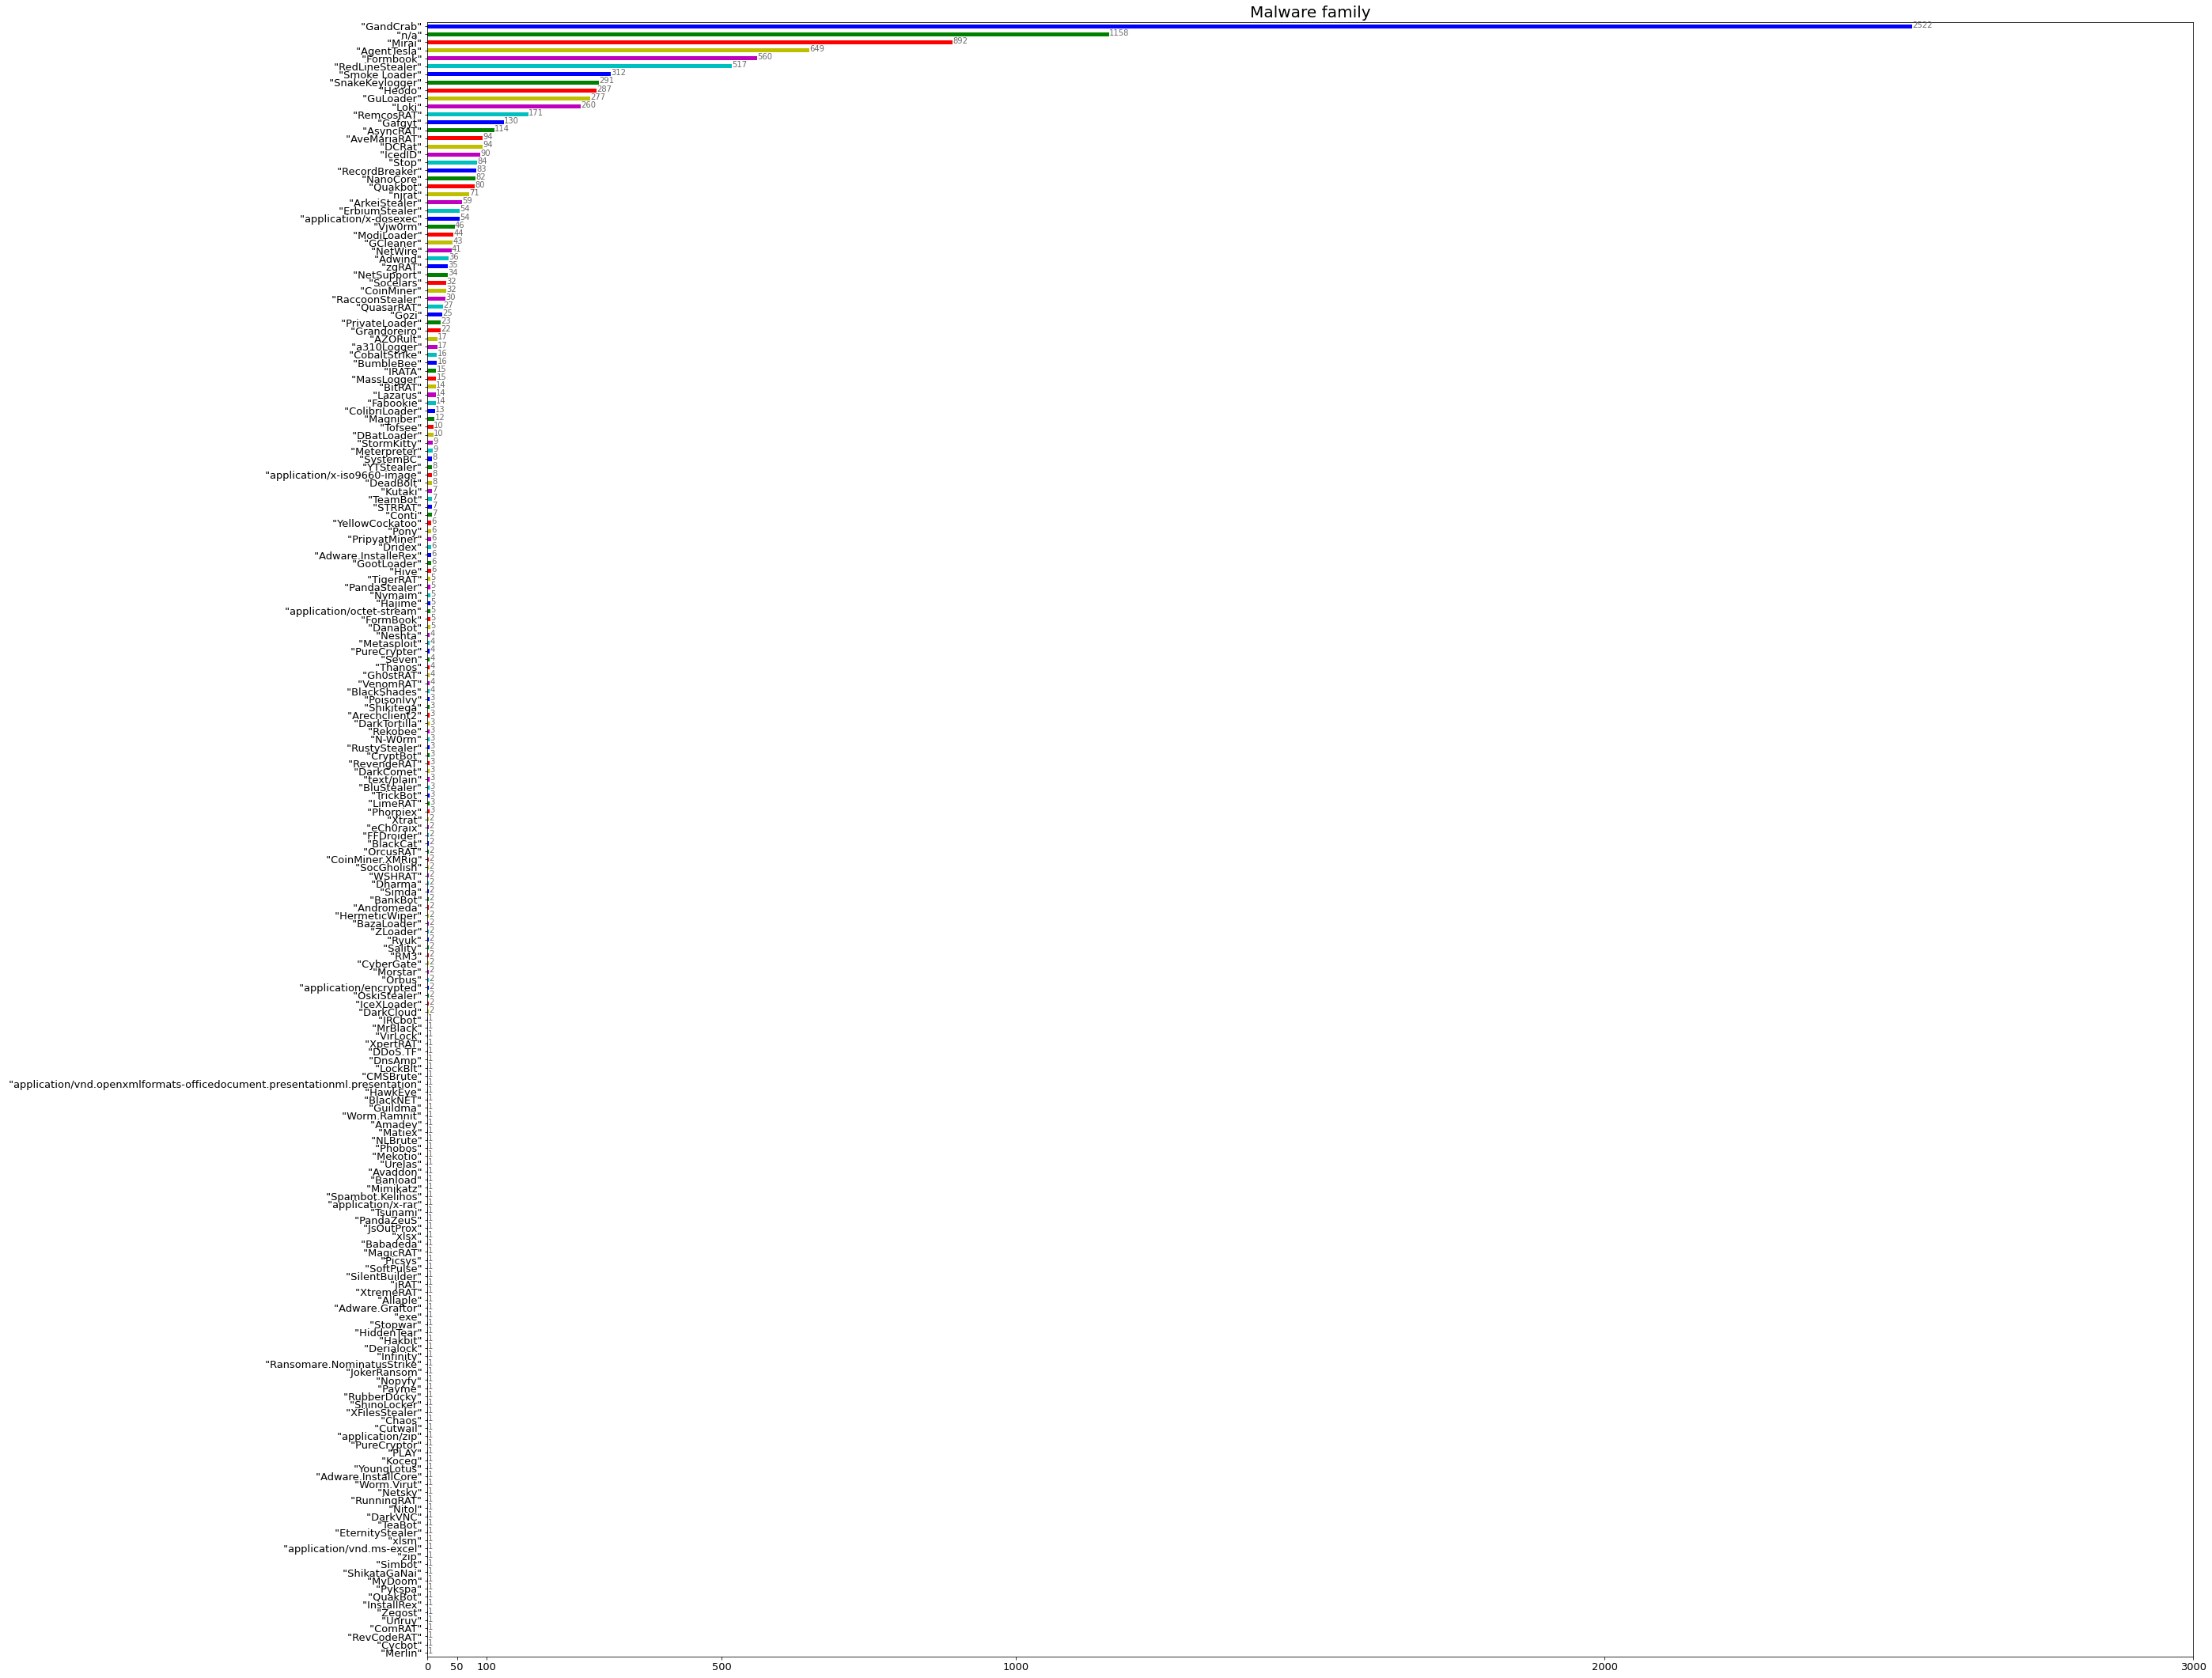

In [50]:
ax = ndoc['signature'].value_counts().plot(kind='barh',figsize=(40,38),
                                        color=['b', 'g', 'r', 'y', 'm', 'c'], fontsize=13);
ax.set_alpha(1)
ax.set_title("Malware family", fontsize=20)

ax.set_xticks([0, 50, 100, 500, 1000, 2000, 3000])

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    #print(i.get_width())
    ax.text(i.get_width()+.3, i.get_y()+.38, i.get_width(),fontsize=10, color='dimgrey')

# invert for largest on top 
ax.invert_yaxis()

## Selecting the malware family to explore. 

In [30]:
ndoc2 = ndoc1[ndoc1["signature"] == "\" RemcosRAT\""]
ndoc2

,vtpercent,reporter,sha256_hash,md5_hash,signature,clamav,mime_type,log,imphash,ssdeep,file_name,tlss,file_type_guess,event,sha1_hash,first_seen_utc


In [31]:
ndoc2['first_seen_utc'] = pd.to_datetime(ndoc2['first_seen_utc']).dt.date

Generate a Timeline of the samples selected.

<AxesSubplot:title={'center':'Timeline of Samples'}, xlabel='first_seen_utc'>

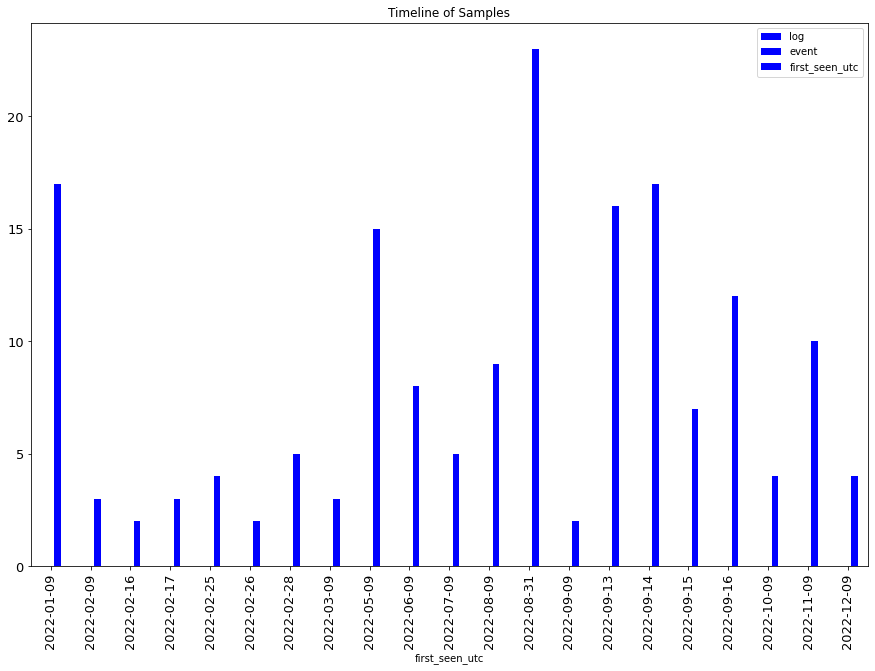

In [78]:
ndoc3 = ndoc2.drop(["sha256_hash","md5_hash","sha1_hash","reporter","file_name","file_type_guess","mime_type","clamav","vtpercent","imphash","ssdeep", "tlss", "signature"], axis=1)
#ndoc2
ndoc3.groupby(ndoc2["first_seen_utc"]).count().plot(kind="bar", title='Timeline of Samples', figsize=(15,10),color=['b'], fontsize=13)


In [80]:
# Filtering by a given date
date_sample = datetime.datetime.strptime("2022-08-31", "%Y-%m-%d")
ndoc2[ndoc2["first_seen_utc"] == date_sample.date()] # use < > for a period of time

,vtpercent,reporter,sha256_hash,md5_hash,signature,clamav,mime_type,log,imphash,ssdeep,file_name,tlss,file_type_guess,event,sha1_hash,first_seen_utc
r_plgoMBxymGDwsHG8TK,60.56,GovCERT_CH,ad4f98ceb515760cc174cdd293caccff12b93d0ef2d2a...,15cb9362d6b81dd4dd2034aee2435466,RemcosRAT,n/a,application/x-dosexec,NaN,f34d5f2d4577ed6d9ceec516c1f5a744,24576:x65j4G2NNf4dDfSObntvmGfw9Lqycisu8HwhEZA...,DOC32022 CR.exe,T13235F1A0E9C04A86DD3D4BB914326C60237B7E677DB...,exe,NaN,a124e5c90a7c67556fd5455faf845610713c01fa,2022-08-31
sPplgoMBxymGDwsHG8TK,29.58,GovCERT_CH,1f6ec2674d9fb0470b67ff0b1ad5901c51d69b8e02a29...,3206af4b57ba4b5ec8d7c42a7b4d9e23,RemcosRAT,n/a,application/x-dosexec,NaN,f34d5f2d4577ed6d9ceec516c1f5a744,24576:eqdT/0shbH16T/0shbm1ptcXxOcNrPAuS2MRKRH...,SEDFEDHC23.exe,T19045F195E6C0C885CD7B6BBA54721D600376BE65BCB...,exe,NaN,f0b1f643b968a9fefa072903c0bd05a98ab190a7,2022-08-31
uPplgoMBxymGDwsHG8TK,44.29,GovCERT_CH,b95ffbf8be23388df6b0d5c48cecdb091b6bbe2e00e00...,8e3877910417b065b44a3316224cedbb,RemcosRAT,n/a,application/x-dosexec,NaN,f34d5f2d4577ed6d9ceec516c1f5a744,24576:xn1i5GFwZ5qb/Z2X/VXQZqPgr+Txzifr6USiW:x...,INV_PackingL_202208031_0104.exe,T1CF35F109FA66CF01E1A81B33C1E1A2444336AE49906...,exe,NaN,2e440aaac32df70ce01460363a77e7873661f9ad,2022-08-31
x_plgoMBxymGDwsHHMRw,55.71,James_inthe_box,698ab228f1aea9326c0a81ce757baf86aa565b6138408...,e6e70485a0a411f6da48ab8ab7763ba2,RemcosRAT,n/a,application/x-dosexec,NaN,f34d5f2d4577ed6d9ceec516c1f5a744,24576:jhPEsHZ5G7wIM+IayhXUKLTxibWEgBVDE4NIHb:...,quotation.exe,T185350209FAA6CB02E1681B33C5E162540335AF45916...,exe,NaN,c534879363fc4156781a23be93ece8c840c2a027,2022-08-31
4fplgoMBxymGDwsHHMRw,49.28,abuse_ch,9caf57d3683dade55209a1635696000cd4cea5f9261a8...,be54e9aaac2041df5f5164fa1751a657,RemcosRAT,n/a,application/x-dosexec,NaN,24b92ccf1e266e626a6cc7126f975fe5,98304:SiElsQcBRrrssBI/7gUy2IoBCJFCIR9JVTQtEMr...,be54e9aaac2041df5f5164fa1751a657.exe,T19116237742561287D4E589368A37FFC171F6137E4F8...,exe,NaN,7c23d7600765a4fcc8ecf04fa15bb761691e95a6,2022-08-31
4vplgoMBxymGDwsHHMRw,53.62,abuse_ch,371d0e3219602c0fd7be91fac46b730e829f2733bd052...,b7a730f51df6a5d1ffd7e2645c037410,RemcosRAT,n/a,application/x-dosexec,NaN,24b92ccf1e266e626a6cc7126f975fe5,98304:+MKH6O75X+P23F/idfvHiW8gVEUww3G4FAiCEH/...,b7a730f51df6a5d1ffd7e2645c037410.exe,T1F816237392680215E5E9CC3ECA273EE135F613B7CE8...,exe,NaN,2f8e31cbc4d08ecd7bceced462c5d2fe03f8fd33,2022-08-31
4_plgoMBxymGDwsHHMRw,49.28,abuse_ch,8a0f4e7fd0176e47c8b254a3814f207fad9535cce012e...,d97696c2f39f22eb70ae51679cd1b500,RemcosRAT,n/a,application/x-dosexec,NaN,24b92ccf1e266e626a6cc7126f975fe5,98304:kDUmPvCTDVuz8MO5MsrGp+IYgw4JdDEjn4JG5XL...,d97696c2f39f22eb70ae51679cd1b500.exe,T14B16122712690189E0C4FCF95537FDA131F11E6E5E4...,exe,NaN,e801a82d4a4dad6bf89d6a526c699d2df677dbcf,2022-08-31
8fplgoMBxymGDwsHHMRw,31.43,abuse_ch,fa9c154abc0b0f5afece4bb8ce5cd81da262d5c1db610...,a01016162f50e4b425061feaeea3c21e,RemcosRAT,n/a,application/x-dosexec,NaN,f34d5f2d4577ed6d9ceec516c1f5a744,24576:Pd2IKjJGMRoTRp6voLSEZ5tVRI3UHBXtJ68IOKj...,ESTADO DE CUENTA DHL - 1606561674.exe,T176857D9C7650B2AFC817CE76CA645C24FA60B96B431...,exe,NaN,b3eb0c6d44b707aef1e1e8c7b3cc728bea6ebe77,2022-08-31
IvplgoMBxymGDwsHHMVw,n/a,SecuriteInfoCom,5d0218eb1cf6bc667948084aa212cd7d659ff27219eca...,8d2257edf759db8cf362cda8ee5f105c,RemcosRAT,n/a,application/x-dosexec,NaN,5761a5265ce04fa03997bb23d07ce92c,24576:FKW7GCyLUdEMCM6tkku4nzSrjXN40JIyLrFHDvk...,SecuriteInfo.com.Variant.Zusy.436436.25834.2239,T16015CFF1B2E14733D01305B8CD6B731D9A7ABF90291...,exe,NaN,091c1a7bc432388761ff5c7fc3175201ddae93b0,2022-08-31
JfplgoMBxymGDwsHHMVw,n/a,SecuriteInfoCom,c020644320b8624f5825b0c6ff537b051b14a0e7f8c4c...,32dd3db4729052ca47102bb5d0721363,RemcosRAT,n/a,application/x-dosexec,NaN,f34d5f2d4577ed6d9ceec516c1f5a744,6144:GTPRHfjHum7kgvJrYuJ6q1tCWMZ5u+PgZLIT6+Rr...,SecuriteInfo.com.Variant.Barys.11488.9974.24726,T10CC49FE4AB88D6B5C8639A78943696E314B3A15E5C9...,exe,NaN,6eec512a216713016539c9a59c1824e18036b923,2022-08-31


# Malware Analysis

This part will download the sample from VT and provide you insight about the malware. For running this part you need a VT Intelligence API.

In [22]:
# Imports and configuration
from IPython.display import display, HTML
from msticpy.sectools import IoCExtract
import matplotlib.pyplot as plt
import sys
import warnings
from msticpy import init_notebook
init_notebook(namespace=globals());

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)

In [24]:
# Loading the VT API key
from msticpy.common.provider_settings import get_provider_settings
from msticpy.sectools.vtlookupv3 import VTLookupV3, VTEntityType
import nest_asyncio
vt_key = get_provider_settings("TIProviders")["VirusTotal"].args["AuthKey"]

# Instantiate vt_lookup object
vt_lookup = VTLookupV3(vt_key)
nest_asyncio.apply()

In [25]:
hash_details = vt_lookup.get_object("c2ed3ba6d8fd0a0cee0d447133c79886", "file")
hash_details

,id,type,type_description,vhash,trid,creation_date,names,last_modification_date,type_tag,times_submitted,size,authentihash,last_submission_date,meaningful_name,downloadable,sha256,autostart_locations,type_extension,tags,last_analysis_date,unique_sources,first_submission_date,sha1,ssdeep,md5,...,last_analysis_results.AVG.category,last_analysis_results.AVG.engine_name,last_analysis_results.AVG.engine_version,last_analysis_results.AVG.result,last_analysis_results.AVG.method,last_analysis_results.AVG.engine_update,last_analysis_results.Panda.category,last_analysis_results.Panda.engine_name,last_analysis_results.Panda.engine_version,last_analysis_results.Panda.result,last_analysis_results.Panda.method,last_analysis_results.Panda.engine_update,last_analysis_results.CrowdStrike.category,last_analysis_results.CrowdStrike.engine_name,last_analysis_results.CrowdStrike.engine_version,last_analysis_results.CrowdStrike.result,last_analysis_results.CrowdStrike.method,last_analysis_results.CrowdStrike.engine_update,last_analysis_results.Qihoo-360.category,last_analysis_results.Qihoo-360.engine_name,last_analysis_results.Qihoo-360.engine_version,last_analysis_results.Qihoo-360.result,last_analysis_results.Qihoo-360.method,last_analysis_results.Qihoo-360.engine_update,context_attributes
0,4ab434bb66a41e89e8d7153c3d0aa8d8aa90e8586864640244ead8417539dc7d,file,Win32 EXE,235036751513c010331247232,"[{'file_type': 'Generic CIL Executable (.NET, Mono, etc.)', 'probability': 62.0}, {'file_type': ...",2060-06-26 05:04:21+00:00,"[ffXAYzXFGfWXkJ.exe, C:\Users\<USER>\AppData\Roaming\bKDhsc.exe, %APPDATA%\bkdhsc.exe, C:\Users\...",2022-06-04 04:19:52+00:00,peexe,1,327168,d32acec96da1a08dded59b116f683213395c5f6e38e15f5a02918bbba569e85d,2020-06-08 01:19:30+00:00,ffXAYzXFGfWXkJ.exe,True,4ab434bb66a41e89e8d7153c3d0aa8d8aa90e8586864640244ead8417539dc7d,[{'entry': 'cmd.exe'}],exe,"[peexe, runtime-modules, assembly, direct-cpu-clock-access, detect-debug-environment]",2020-06-23 03:18:57+00:00,1,2020-06-08 01:19:30+00:00,99fe45bde9a1287928f3be8eee3a662f2f83c99a,6144:gF//NuQBJKK/1dES8qwLU6ENFvcfWeVMNaVnB9Nr:gFtX1dLwYZcfWgMwfz,c2ed3ba6d8fd0a0cee0d447133c79886,...,malicious,AVG,18.4.3895.0,Win32:PWSX-gen [Trj],blacklist,20200623,malicious,Panda,4.6.4.2,Trj/GdSda.A,blacklist,20200622,malicious,CrowdStrike,1.0,win/malicious_confidence_80% (W),blacklist,20190702,malicious,Qihoo-360,1.0.0.1120,Generic/Trojan.PSW.374,blacklist,20200623,None


In [26]:
contacted_domain = vt_lookup.lookup_ioc_relationships(observable = "c2ed3ba6d8fd0a0cee0d447133c79886",  vt_type = 'file', relationship = 'contacted_domains')
contacted_domain

,index,target_type,target,source,source_type,relationship_type
0,0,domain,ifeanyiogbunebe.ddns.net,c2ed3ba6d8fd0a0cee0d447133c79886,file,contacted_domains


In [28]:
# Instantiate vt_lookup object
DOMAIN = "ifeanyiogbunebe.ddns.net"
ip_relation = vt_lookup.lookup_ioc_relationships(observable = DOMAIN, vt_type = 'domain', relationship = 'communicating_files')
ip_relation

,index,target_type,target,source,source_type,relationship_type
0,0,file,063cee4d23dc9351a9805b239fb6ddd531af5d7a4657919b5feeab757f877ec7,ifeanyiogbunebe.ddns.net,domain,communicating_files
1,1,file,08481f8db93e8a65816896f525dfa3f862efae12ac7f6a7019359a540da1ed5a,ifeanyiogbunebe.ddns.net,domain,communicating_files
2,2,file,0fa2f395f9a33628e72c59610d0b2d03f786253c316a543dc43049d9c7b60193,ifeanyiogbunebe.ddns.net,domain,communicating_files
3,3,file,2b9d20dda8529c9c382c5f2adc8eb966ec46590a15f056ba436d1b07c5b61e4f,ifeanyiogbunebe.ddns.net,domain,communicating_files
4,4,file,2f7d3818cb8817b62b05cf51c6f7b76fb8f1998e9415ea6d673cd99192f157fa,ifeanyiogbunebe.ddns.net,domain,communicating_files
5,5,file,313a41fbc3104d06f0930f422d0ac01d6113cbe01be85c9024873ee7f0214b02,ifeanyiogbunebe.ddns.net,domain,communicating_files
6,6,file,3ef7a562fd424f07acbfbe780103711c091820daaf0197ce05b12b1234687ead,ifeanyiogbunebe.ddns.net,domain,communicating_files
7,7,file,407a7b16290d1ecc76754a51c978f1e98e70bc33a8ab3873919bbe70b2e35a93,ifeanyiogbunebe.ddns.net,domain,communicating_files
8,8,file,4ab434bb66a41e89e8d7153c3d0aa8d8aa90e8586864640244ead8417539dc7d,ifeanyiogbunebe.ddns.net,domain,communicating_files
9,9,file,699974f01e14d388688519289de1eb560817c493bb1e96133e3bb668bc25b379,ifeanyiogbunebe.ddns.net,domain,communicating_files


## Yara Scan

In [75]:
import yara

rules = yara.compile("RAT2.yar")

def yarascan(filename, rules):
    try:
        matches = rules.match(filename)
    except ValueError as e:
        print(e)
    if matches:
        return matches
    return

In [76]:
yarascan(filename, rules)

[win_remcos_auto]

# Conclusion

This short notebook shows how to explore an index in ELK and retrieve the data. It then demonstrates how to generate some graphs to visualize the data and finally how to use MSTICpy to pivot of some information and uncover additional threats. 